# Introduction #

In Lessons 2 and 3, we treated forecasting as a simple regression problem with all of our features derived from a single input, the time index. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features.

When we added lag features in Lesson 4, however, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

In Lesson 4, we just assumed that we could always generate lags up to the period we wanted to forecast (every prediction was for just one step forward, in other words). Real-world forecasting typically demands more than this, so in this lesson we'll learn how to make forecasts for a variety of situations.

# Defining the Forecasting Task #

There are two things to establish before designing a forecasting model:
- what information is available at the time a forecast is made (features), and, : 예측이 이루어지는 시점에 어떤 정보(features) 사용 가능한가
- the time period during which you require forecasted values (target). : 예측값 도출에 필요한 시간구간은?

The **forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.

1. **forcast origin**
- 정의: 예측을 수행하는 시점
- 실제 의미: 예측을 하고자 하는 시간에 대해 마지막으로 보유한 학습 데이터의 시점.
- 활용: 예측 시점 이전의 모든 데이터를 피처 생성에 사용 가능.
2. **forcast horizon**
- 정의: 예측을 하고자 하는 시간 범위
- 표현 방법: 예측 범위의 시간 단계 수로 표현(ex. 1-step, 5-step)
- 설명: 예측 대상(target)을 설명하는 용어.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/xwEgcOk.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>A three-step forecast horizon with a two-step lead time, using four lag features. The figure represents what would be a single row of training data -- data for a single prediction, in other words.
</center></figcaption>
</figure>

The time between the origin and the horizon is the **lead time** (or sometimes *latency*) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

# Preparing Data for Forecasting #

코드 복사
### Time Series 예측을 위한 데이터프레임 변환

1. **기본 개요**:

   - 머신 러닝 알고리즘을 사용하여 시계열 데이터를 예측하려면, 해당 시계열 데이터를 데이터프레임으로 변환해야 합니다.
   - 단, 트렌드와 계절성 같은 결정론적 피처만 사용하는 경우는 예외입니다.


2. **과정 요약**:

   - 첫 번째 단계는 래그(lag)를 사용하여 피처 세트를 만드는 것입니다. 이는 Lesson 4에서 다루었습니다.
   - 두 번째 단계는 타겟 준비입니다. 이 단계는 예측 작업에 따라 다릅니다.


3. **데이터프레임 구조**:

   - 데이터프레임의 각 행은 하나의 예측을 나타냅니다.
   - 행의 시간 인덱스는 예측 기간의 첫 번째 시간입니다.
   - 전체 예측 기간의 값을 동일한 행에 배치합니다.
   - 다단계 예측(multistep forecast)의 경우, 각 단계에 대해 모델이 여러 출력을 생성하도록 요구합니다.


In [3]:
import numpy as np
import pandas as pd

# 시계열 데이터 생성
N = 20  # 20개의 기간을 생성
ts = pd.Series(
    np.arange(N),  # 0부터 N-1까지의 정수 배열을 생성
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),  # 2010년부터 시작하는 연간 주기의 기간 인덱스를 생성
    dtype=pd.Int8Dtype,  # 데이터 타입을 Int8로 설정
)

# 래그 피처 생성
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),  # 2 기간 전의 값을 래그 피처로 생성
    'y_lag_3': ts.shift(3),  # 3 기간 전의 값을 래그 피처로 생성
    'y_lag_4': ts.shift(4),  # 4 기간 전의 값을 래그 피처로 생성
    'y_lag_5': ts.shift(5),  # 5 기간 전의 값을 래그 피처로 생성
    'y_lag_6': ts.shift(6),  # 6 기간 전의 값을 래그 피처로 생성
})

# 다단계 타겟 생성
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),  # 2 기간 후의 값을 타겟으로 생성
    'y_step_2': ts.shift(-1),  # 1 기간 후의 값을 타겟으로 생성
    'y_step_1': ts,  # 현재 기간의 값을 타겟으로 생성
})

# 타겟과 피처 합치기
data = pd.concat({'Targets': y, 'Features': X}, axis=1)  # 타겟과 피처를 하나의 데이터프레임으로 결합하고, 다중 인덱스를 사용하여 구분

# 데이터프레임 스타일 설정
data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})


/tmp/ipykernel_33/3685143276.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),  # 2010년부터 시작하는 연간 주기의 기간 인덱스를 생성
/tmp/ipykernel_33/3685143276.py:6: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  ts = pd.Series(


The above illustrates how a dataset would be prepared similar to the *Defining a Forecast* figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is "원래 시계열값 : `y_step_1`". The missing values we could either fill-in or drop.

# Multistep Forecasting Strategies #

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

## 일반적인 4가지 전략

### 1. Multioutput model

Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

- 여러 출력을 생성하는 모델 사용 (Linear regression, neural networks)
- 간단, 효율적이지만 모든 알고리즘에 적용 불가(ex. XGBoost)

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/uFsHiqr.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### 2. Direct strategy

- 각 스텝마다 별도의 모델을 훈련시킴으로써 예측 정확도를 높임 
- 각 스텝의 예측 문제는 서로 다르기 때문에, 스텝별로 다른 모델을 사용하면 더 나은 예측 성능을 얻을 수 있음
- 비싼 계산 비용의 단점

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HkolNMV.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### 3. Recursive strategy

- 단일 1-step 모델을 훈련시키고, 그 예측값을 사용하여 다음 스텝의 lag features를 업데이트
- 여러 스텝 예측 가능
- 스텝이 진행될수록 오류가 누적되어 긴 예측 기간에서는 예측 정확도가 떨어짐

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/sqkSFDn.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### 4. DirRec strategy

- Direct와 Recursive 전략의 결합으로, 각 스텝마다 모델을 훈련시키고 이전 스텝의 예측값을 새로운 lag features로 사용
- 각 스텝마다 추가적인 래그 입력을 사용하여, 연속적인 종속성을 더 잘 포착
- 긴 예측에서 오류전파 문제 여전히 존재

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/B7KAvAO.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

# Example - Flu Trends #

In this example we'll apply the MultiOutput and Direct strategies to the *Flu Trends* data from Lesson 4, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

- 1-week lead time
- 8-week hrizon(예측 구간)

The hidden cell sets up the example and defines a helper function `plot_multistep`.

In [5]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


# 다단계 예측 결과를 시각화하는 함수 정의
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    # 기본 팔레트 설정
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)  # 사용자 지정 팔레트가 있으면 업데이트
    palette = sns.color_palette(**palette_kwargs_)  # 팔레트 생성
    if ax is None:
        fig, ax = plt.subplots()  # Axes가 지정되지 않으면 새로운 figure와 axes 생성
    ax.set_prop_cycle(plt.cycler('color', palette))  # Axes의 색상 사이클 설정
    for date, preds in y[::every].iterrows():  # 주어진 데이터의 각 행에 대해 반복
        preds.index = pd.period_range(start=date, periods=len(preds))  # 예측 값의 인덱스를 날짜 범위로 설정
        preds.plot(ax=ax)  # 예측 값을 플롯
    return ax  # Axes 반환

# 데이터 디렉토리 설정
data_dir = Path("../input/ts-course-data")

# 플루 트렌드 데이터 로드
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")

# 인덱스를 PeriodIndex로 설정
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),  # 'Week' 컬럼을 주간 주기의 PeriodIndex로 변환하여 설정
    inplace=True,
)

# 'Week' 컬럼을 데이터프레임에서 제거
flu_trends.drop("Week", axis=1, inplace=True)

First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [6]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)

# 각 스텝마다 시계열 데이터를 일정 간격만큼 시프트하여 새로운 컬럼(target)으로 추가
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i) # 미래의 값을 현재 시점으로 이동
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
# 타겟과 피처의 인덱스를 일치시키기 위해 정렬
y, X = y.align(X, join='inner', axis=0)

### Multioutput model

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [7]:

# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 389.12
Test RMSE: 582.33


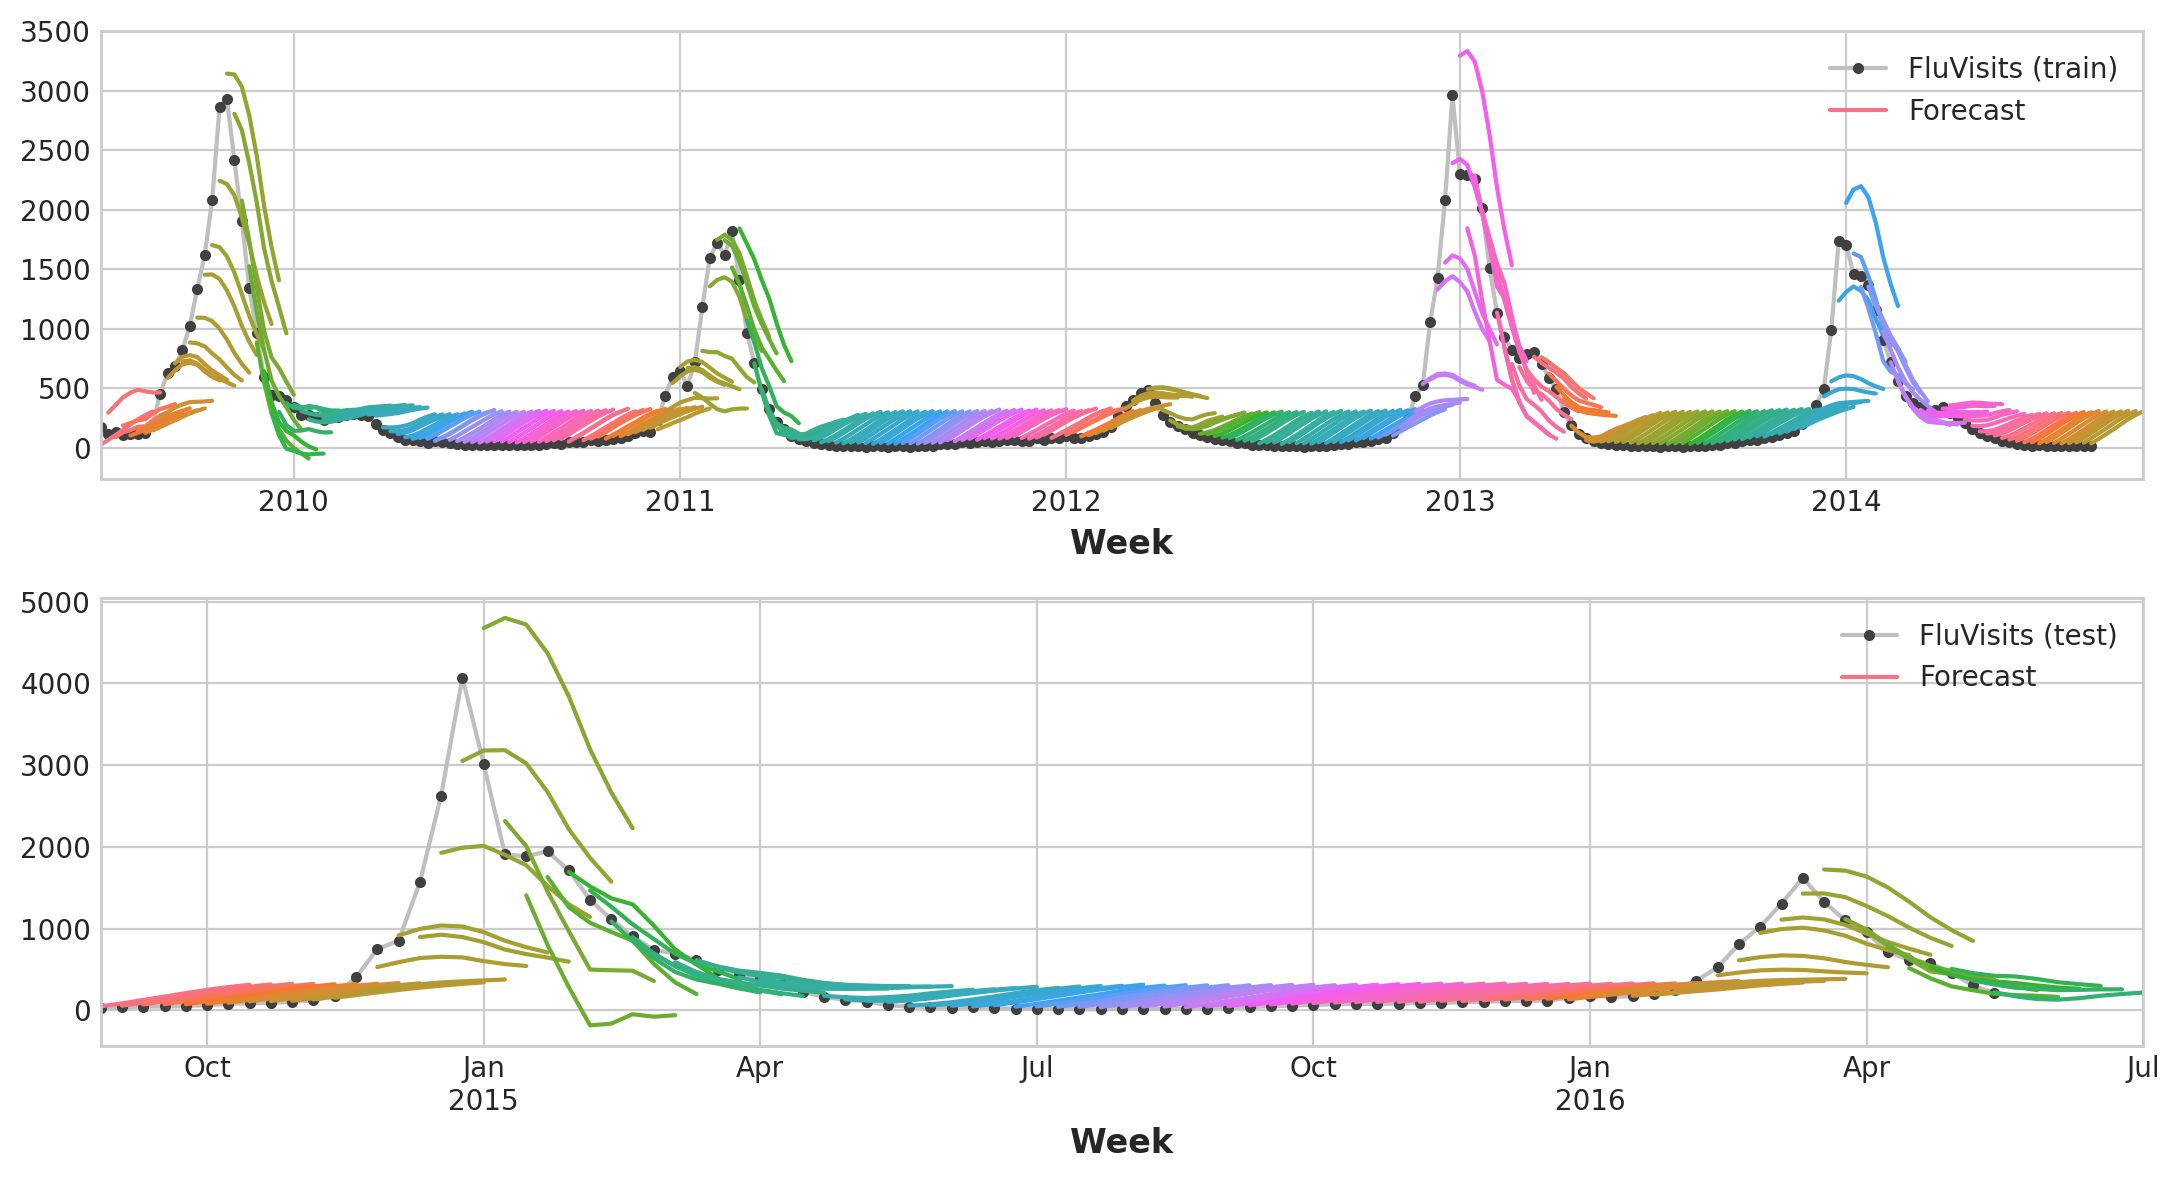

In [8]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False) # squared=False로 RMSE 구현
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [9]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

Train RMSE: 1.19
Test RMSE: 494.52


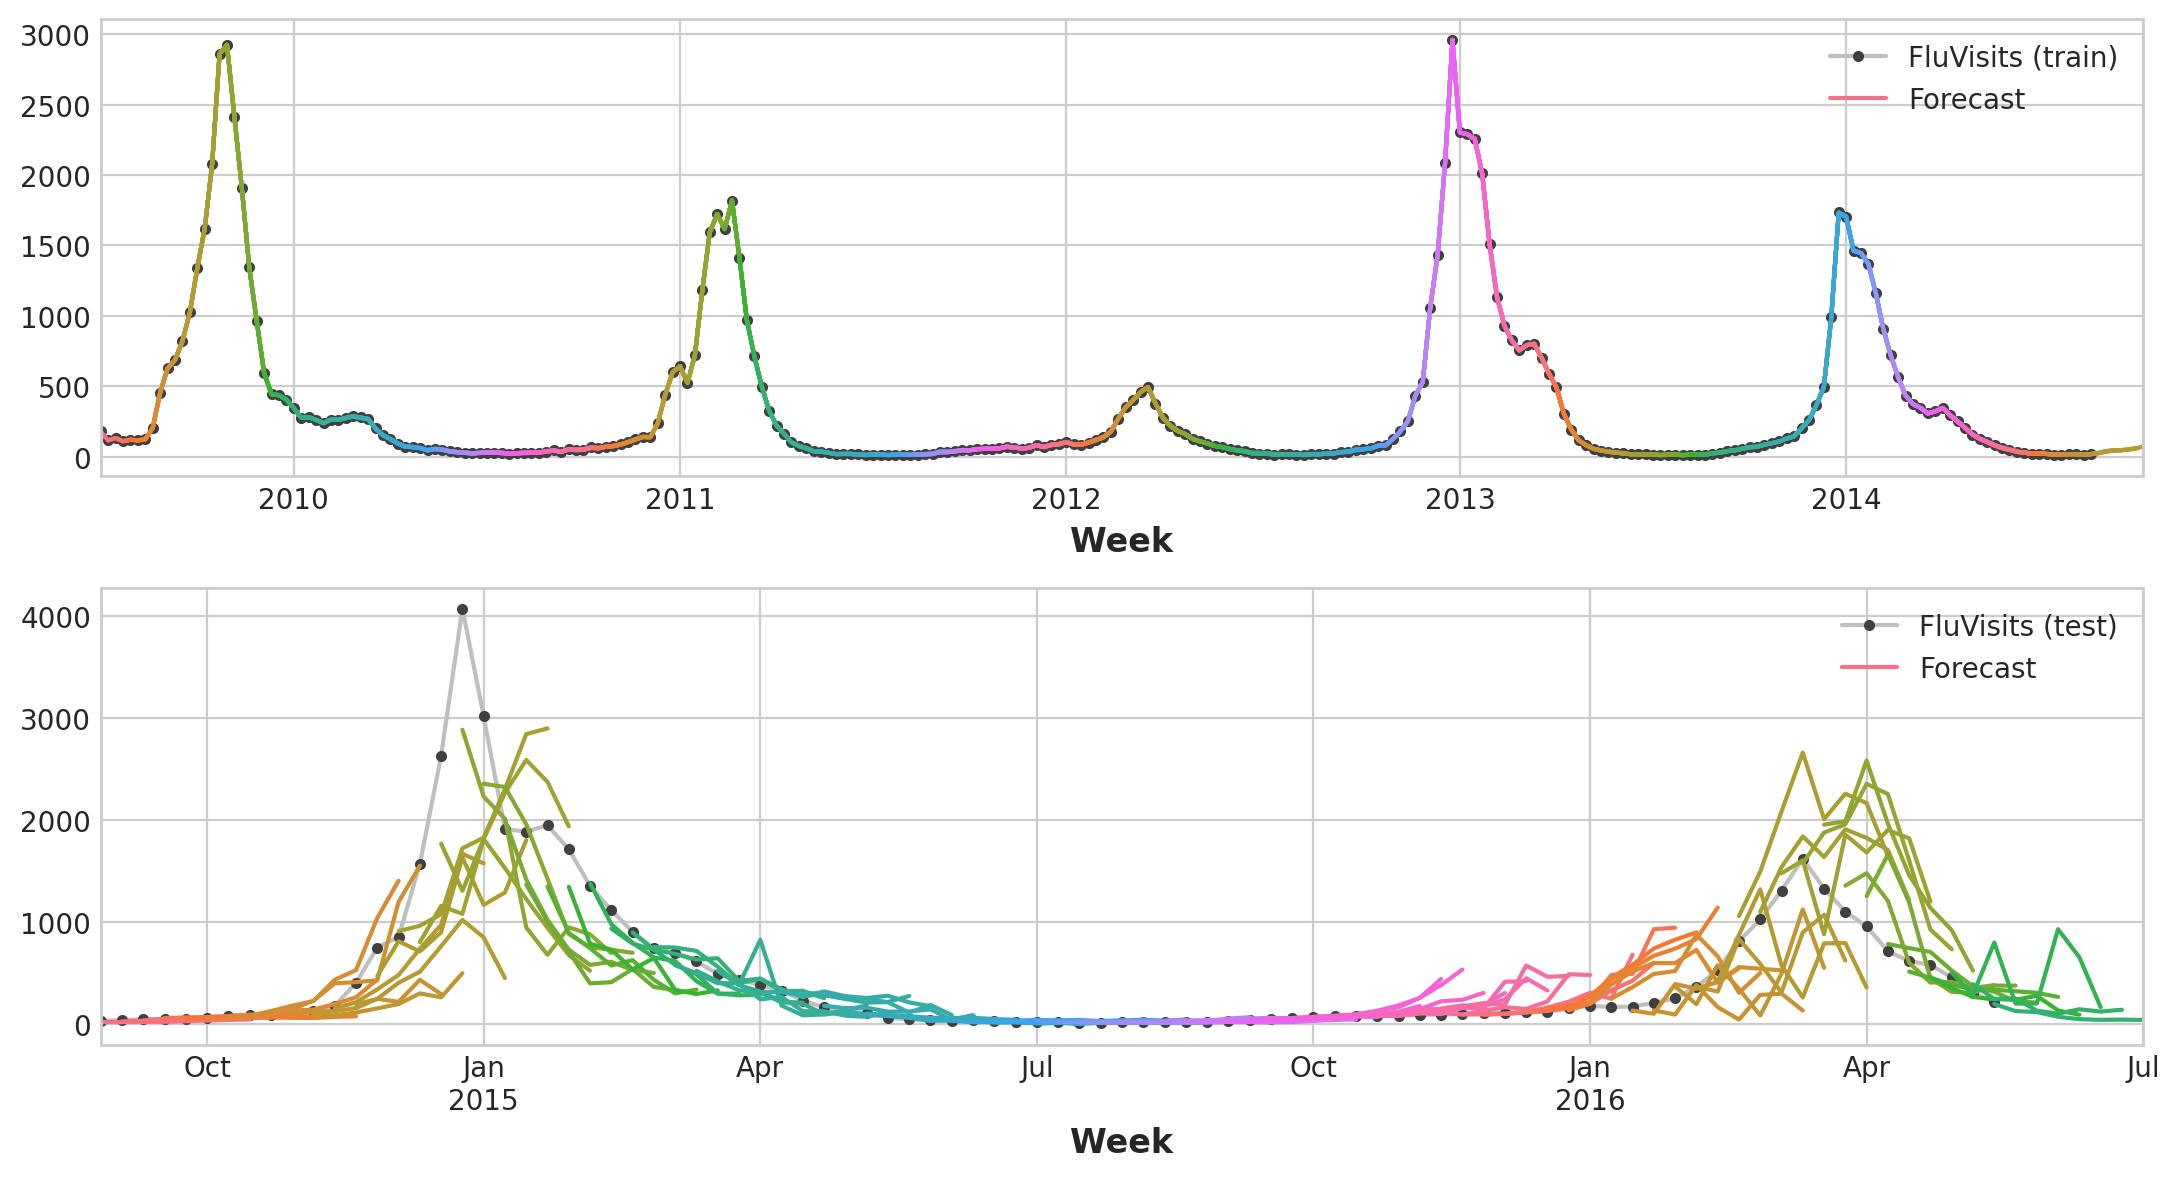

In [10]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`. The Recursive strategy we would need to code ourselves.

# Your Turn #

[**Create a forecasting dataset**](https://www.kaggle.com/kernels/fork/20667477) for *Store Sales* and apply the DirRec strategy.

In [11]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 112.72
Test RMSE: 560.74


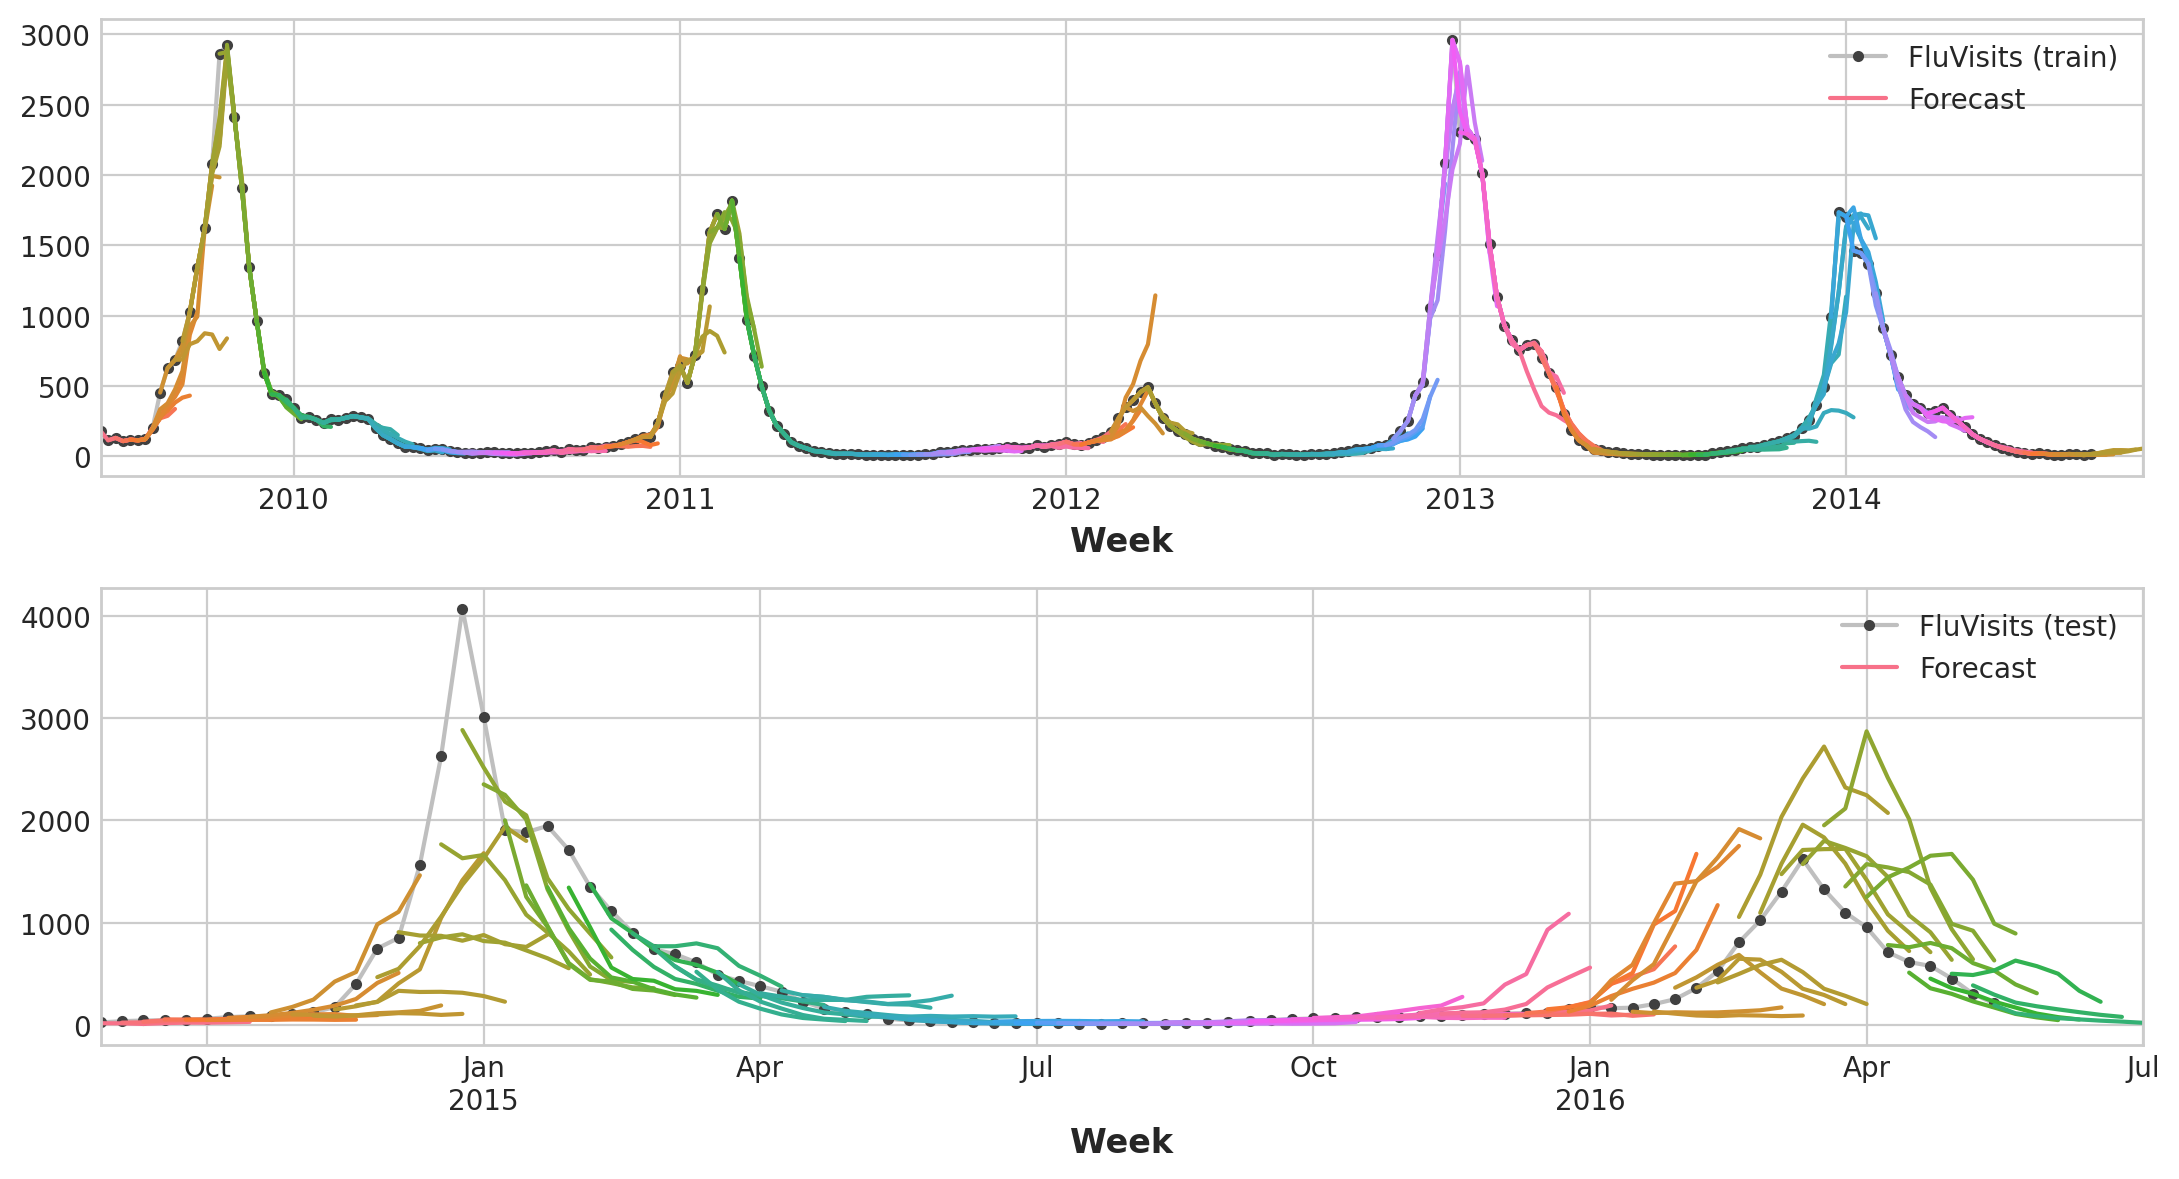

In [12]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*